In [42]:
import pandas as pd
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from category_encoders import TargetEncoder
from sklearn.feature_selection import SelectFromModel

from pathlib import Path
from tqdm import tqdm
from config import param_boost
pd.set_option('display.max_columns', None)

In [2]:
path = '../../prepare_data/data/df_general.csv'

df = pd.read_csv(Path(path).resolve())
y = df['team_1_hue']

df.drop(['team_1_hue', 'match_id'], axis=1, inplace=True)

In [3]:
df

gameweek_gameweek  gameweek_compSeason_label    teams_team_1_name  \
0                     1                       2014              Arsenal   
1                     1                       2014       Leicester City   
2                     1                       2014    Manchester United   
3                     1                       2014  Queens Park Rangers   
4                     1                       2014           Stoke City   
...                 ...                        ...                  ...   
3367                 22                       2023            Liverpool   
3368                 22                       2023      Manchester City   
3369                 23                       2023              Burnley   
3370                 23                       2023              Everton   
3371                 23                       2023     Sheffield United   

      teams_team_2_name month day_week  hour  ground_id  \
0        Crystal Palace   Aug      Sat    17         52   
1               Everton   Aug      Sat    15         49   
2          Swansea City   Aug      Sat    12         42   
3             Hull City   Aug      Sat    15         46   
4           Aston Villa   Aug      Sat    15        435   
...                 ...   ...      ...   ...        ...   
3367            Chelsea   Jan      Wed    20        901   
3368            Burnley   Jan      Wed    19        457   
3369             Fulham   Feb      Sat    15         47   
3370  Tottenham Hotspur   Feb      Sat    12         31   
3371        Aston Villa   Feb      Sat    17       2003   

      _accurate_back_zone_pass_team_1  _accurate_chipped_pass_team_1  \
0                         7925.444444                     693.777778   
1                         6395.666667                     663.222222   
2                         7671.666667                     724.222222   
3                         4135.000000                     574.000000   
4                         5308.250000                     590.500000   
...                               ...                            ...   
3367                      8856.333333                     844.333333   
3368                      9053.555556                     732.666667   
3369                      4202.000000                     598.428571   
3370                      6304.777778                     615.222222   
3371                      4923.500000                     555.500000   

      _accurate_corners_intobox_team_1  _accurate_cross_team_1  \
0                            51.222222              150.333333   
1                            46.666667              146.777778   
2                            49.000000              153.444444   
3                            67.000000              182.000000   
4                            53.000000              157.750000   
...                                ...                     ...   
3367                         62.111111              180.222222   
3368                         72.555556              173.000000   
3369                         52.285714              171.428571   
3370                         52.111111              164.666667   
3371                         48.500000              161.500000   

      _accurate_cross_nocorner_team_1  _accurate_flick_on_team_1  \
0                          101.111111                  63.444444   
1                          102.777778                  99.222222   
2                          107.000000                  73.222222   
3                          116.000000                 137.000000   
4                          106.250000                 144.500000   
...                               ...                        ...   
3367                       119.888889                  63.222222   
3368                       105.777778                  47.888889   
3369                       120.000000                 119.000000   
3370                       113.333333                  75.

In [4]:
#Признаки со смещением (лаги)
lag_features = [
            'result_lag_1_team_1',
            'result_lag_2_team_1',
            'result_lag_3_team_1',
            'result_lag_4_team_1',
            'result_lag_5_team_1',
            'result_lag_1_team_2',
            'result_lag_2_team_2',
            'result_lag_3_team_2',
            'result_lag_4_team_2',
            'result_lag_5_team_2',
            'game_lag_1',
            'game_lag_2',
            'game_lag_3'
            ]

In [5]:
cat_cols = [
            'gameweek_gameweek',
            'gameweek_compSeason_label',
            'ground_id',
           ]

In [6]:
cat_cols += df.describe(include='object').columns.to_list() + lag_features

In [7]:
df.loc[:, cat_cols]

,gameweek_gameweek,gameweek_compSeason_label,ground_id,teams_team_1_name,teams_team_2_name,month,day_week,F_0_name_team_1,F_1_name_team_1,F_2_name_team_1,M_0_name_team_1,M_1_name_team_1,M_2_name_team_1,M_3_name_team_1,M_4_name_team_1,M_5_name_team_1,D_0_name_team_1,D_1_name_team_1,D_2_name_team_1,D_3_name_team_1,D_4_name_team_1,D_5_name_team_1,D_6_name_team_1,GK_0_name_team_1,F_0_name_team_2,F_1_name_team_2,F_2_name_team_2,M_0_name_team_2,M_1_name_team_2,M_2_name_team_2,M_3_name_team_2,M_4_name_team_2,M_5_name_team_2,D_0_name_team_2,D_1_name_team_2,D_2_name_team_2,D_3_name_team_2,D_4_name_team_2,D_5_name_team_2,D_6_name_team_2,GK_0_name_team_2,result_lag_1_team_1,result_lag_2_team_1,result_lag_3_team_1,result_lag_4_team_1,result_lag_5_team_1,result_lag_1_team_2,result_lag_2_team_2,result_lag_3_team_2,result_lag_4_team_2,result_lag_5_team_2,game_lag_1,game_lag_2,game_lag_3
0,1,2014,52,Arsenal,Crystal Palace,Aug,Sat,Alexis Sánchez,Olivier Giroud,Danny Welbeck,Santi Cazorla,Aaron Ramsey,Alex Oxlade-Chamberlain,Mathieu Flamini,Mathieu Flamini,Mesut Özil,Per Mertesacker,Nacho Monreal,Laurent Koscielny,Calum Chambers,Kieran Gibbs,Héctor Bellerín,Mathieu Debuchy,David Ospina,Wilfried Zaha,Dwight Gayle,Fraizer Campbell,Jason Puncheon,Yannick Bolasie,James McArthur,Joe Ledley,Mile Jedinak,Adlène Guédioura,Joel Ward,Scott Dann,Martin Kelly,Damien Delaney,Brede Hangeland,Adrian Mariappa,Pape Souaré,Julian Speroni,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014,49,Leicester City,Everton,Aug,Sat,Leonardo Ulloa,Jamie Vardy,David Nugent,Jeffrey Schlupp,Esteban Cambiasso,Riyad Mahrez,Matty James,Andy King,Danny Drinkwater,Wes Morgan,Ritchie De Laet,Paul Konchesky,Marcin Wasilewski,Robert Huth,Danny Simpson,Liam Moore,Kasper Schmeichel,Romelu Lukaku,Steven Naismith,Samuel Eto'o,Gareth Barry,Kevin Mirallas,Ross Barkley,James McCarthy,Muhamed Besic,Leon Osman,Phil Jagielka,Séamus Coleman,Leighton Baines,John Stones,Sylvain Distin,Antolín Alcáraz,Bryan Oviedo,Tim Howard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2014,42,Manchester United,Swansea City,Aug,Sat,Wayne Rooney,Robin van Persie,Radamel Falcao,Juan Mata,Ángel Di María,Marouane Fellaini,Ander Herrera,Adnan Januzaj,Michael Carrick,Antonio Valencia,Ashley Young,Chris Smalling,Daley Blind,Phil Jones,Marcos Rojo,Luke Shaw,David de Gea,Bafétimbi Gomis,Wilfried Bony,Marvin Emnes,Ki Sung-Yeung,Nathan Dyer,Gylfi Sigurdsson,Jonjo Shelvey,Jefferson Montero,Wayne Routledge,Ashley Williams,Neil Taylor,Federico Fernández,Angel Rangel,Jordi Amat,Kyle Naughton,Kyle Bartley,Lukasz Fabianski,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2014,46,Queens Park Rangers,Hull City,Aug,Sat,Charlie Austin,Bobby Zamora,Eduardo Vargas,Karl Henry,Leroy Fer,Joey Barton,Matt Phillips,Niko Kranjcar,Junior Hoilett,Steven Caulker,Mauricio Isla,Yun Suk-Young,Nedum Onuoha,Richard Dunne,Clint Hill,Armand Traore,Robert Green,Nikica Jelavic,Abel Hernández,Sone Aluko,Jake Livermore,Tom Huddlestone,David Meyler,Stephen Quinn,Robert Brady,Gastón Ramírez,Ahmed El Mohamady,Michael Dawson,Andy Robertson,James Chester,Alex Bruce,Curtis Davies,Paul McShane,Allan McGregor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2014,435,Stoke City,Aston Villa,Aug,Sat,Mame Diouf,Peter Crouch,Jonathan Walters,Steven Nzonzi,Charlie Adam,Glenn Whelan,Victor Moses,Stephen Ireland,Steve Sidwell,Ryan Shawcross,Erik Pieters,Marc Wilson,Geoff Cameron,Phil Bardsley,Muniesa,Philipp Wollscheid,Asmir Begovic,Gabriel Agbonlahor,Andreas Weimann,Christian Benteke,Tom Cleverley,Fabian Delph,Carlos Sánchez,Ashley Westwood,Charles N'Zogbia,Leandro Bacuna,Alan Hutton,Ciaran Clark,Aly Cissokho,Jores Okore,Kieran Richardson,Ron Vlaar,Matthew Lowton,Brad Guzan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [8]:
# Заменим наны на 999, для деревянных моделей это норм
df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(999)

In [9]:
df[lag_features] = df[lag_features].astype(int)

In [10]:
class_counts = np.bincount(y) #количество экземпляров каждого класса
total_samples = np.sum(class_counts) #общее количество экземпляров
class_weights = total_samples / (len(class_counts) * class_counts) #веса классов
class_weights

array([1.04363974, 0.73464052, 1.46928105])

In [11]:
#Делаем кросс валидацию как в времянных рядах, 20 фолдов по 20 игр
preds = []
tests = []
tscv = TimeSeriesSplit(n_splits=20, test_size=20)
for train_index, test_index in tscv.split(df, y):
    X_train = df.iloc[train_index]
    y_train = y.iloc[train_index]

    X_test = df.iloc[test_index]
    y_test = y.iloc[test_index]
    
    model = CatBoostClassifier(verbose=False, loss_function='MultiClass', task_type='GPU', **param_boost)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_cols, plot=False)
    pred = model.predict(X_test)
    preds.extend(pred.reshape(-1).tolist())
    tests.extend(y_test.tolist())
    print('f1 score weighted:', f1_score(y_test, pred, average='weighted'))

f1 score weighted: 0.5133333333333333
f1 score weighted: 0.4444444444444445
f1 score weighted: 0.4666666666666667
f1 score weighted: 0.3238095238095238
f1 score weighted: 0.4686274509803921
f1 score weighted: 0.6792857142857143
f1 score weighted: 0.45026455026455026
f1 score weighted: 0.2730650154798761
f1 score weighted: 0.684051724137931
f1 score weighted: 0.6533333333333333
f1 score weighted: 0.35138888888888886
f1 score weighted: 0.5118881118881119
f1 score weighted: 0.5714285714285714
f1 score weighted: 0.5475
f1 score weighted: 0.6281481481481481
f1 score weighted: 0.5725490196078431
f1 score weighted: 0.4666666666666667
f1 score weighted: 0.3847826086956522
f1 score weighted: 0.6
f1 score weighted: 0.38636363636363635


In [12]:
print(f"f1 score: {f1_score(tests, preds, average='weighted')}\naccuracy: {accuracy_score(tests, preds)}")

f1 score: 0.49371498733788655
accuracy: 0.5625


In [13]:
#Добавим веса классов для улучшения метрики f1
preds, tests, proba = [], [], []


for train_index, test_index in tscv.split(df, y):
    X_train = df.iloc[train_index]
    y_train = y.iloc[train_index]

    X_test = df.iloc[test_index]
    y_test = y.iloc[test_index]

    class_counts = np.bincount(y_train) #количество экземпляров каждого класса
    total_samples = np.sum(class_counts) #общее количество экземпляров
    class_weights = total_samples / (len(class_counts) * class_counts) #веса классов
    
    model = CatBoostClassifier(verbose=False, class_weights=class_weights, loss_function='MultiClass', task_type='GPU', **param_boost)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_cols, plot=False)
    pred = model.predict(X_test)
    proba.extend(model.predict_proba(X_test))
    preds.extend(pred.reshape(-1).tolist())
    tests.extend(y_test.tolist())
    print('f1 score weighted:', f1_score(y_test, pred, average='weighted'))

f1 score weighted: 0.43
f1 score weighted: 0.4984126984126984
f1 score weighted: 0.557754010695187
f1 score weighted: 0.37540106951871655
f1 score weighted: 0.5736507936507936
f1 score weighted: 0.6700000000000002
f1 score weighted: 0.4867753623188406
f1 score weighted: 0.32291666666666663
f1 score weighted: 0.608468899521531
f1 score weighted: 0.706772575250836
f1 score weighted: 0.4914832535885167
f1 score weighted: 0.6
f1 score weighted: 0.65
f1 score weighted: 0.7009803921568627
f1 score weighted: 0.5826839826839827
f1 score weighted: 0.5627450980392157
f1 score weighted: 0.40341880341880343
f1 score weighted: 0.4020833333333333
f1 score weighted: 0.5260869565217392
f1 score weighted: 0.5402777777777777


In [14]:
print(f"f1 score: {f1_score(tests, preds, average='weighted')}\naccuracy: {accuracy_score(tests, preds)}")

f1 score: 0.5322603970470439
accuracy: 0.525


In [16]:
print(f"f1 score: {f1_score(tests_forest, preds_forest, average='weighted')}\naccuracy: {accuracy_score(tests_forest, preds_forest)}")

f1 score: 0.36434995112414464
accuracy: 0.38


Установим порог предсказания 0.42

In [17]:
predict, indx = [], []
for id, prob in enumerate(proba):
    if max(prob) > 0.42:
        predict.append(np.argmax(prob))
        indx.append(id)

In [18]:
new_test = np.take(tests, indx)
print(len(tests), len(new_test))

400 191


In [19]:
result = pd.DataFrame({'predict': predict, 'test': new_test})
result['error'] = np.where(result['predict'] == result['test'], 0, 1)
print(f'f1_score: {f1_score(new_test, predict, average="weighted")}\naccuracy: {accuracy_score(new_test, predict)}')

f1_score: 0.62832843483238
accuracy: 0.680628272251309


In [20]:
result['test']

0      0
1      1
2      1
3      1
4      0
      ..
186    1
187    0
188    1
189    1
190    2
Name: test, Length: 191, dtype: int64

<AxesSubplot:xlabel='test', ylabel='Count'>

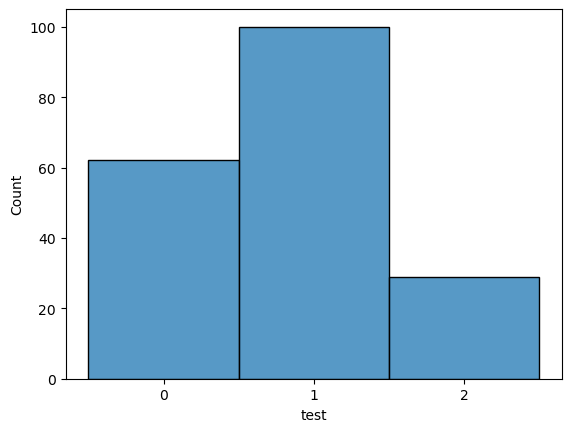

In [21]:
sns.histplot(result['test'].astype(str))

<AxesSubplot:xlabel='test', ylabel='Count'>

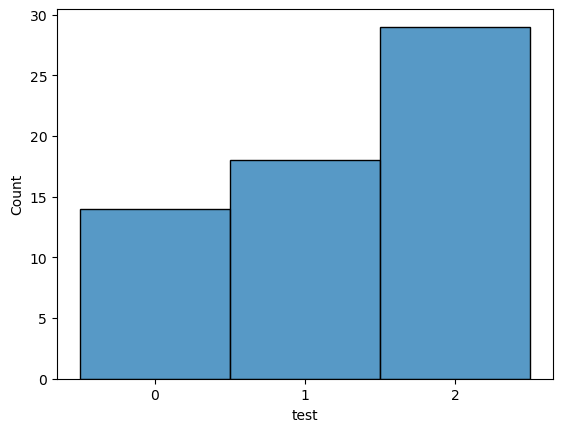

In [22]:
err = result[result['error'] == 1]
sns.histplot(err['test'].astype(str))

<AxesSubplot:xlabel='predict', ylabel='Count'>

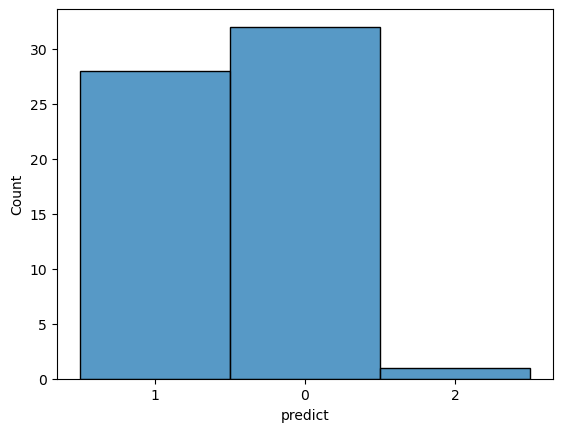

In [23]:
sns.histplot(err['predict'].astype(str))

Если модель предиктит ничью, то она очень редко ошибается, будем предиктить ничью при меньшей увернности. А по победе/поражению понизим уверенность

In [24]:
predict, indx = [], []
for id, prob in enumerate(proba):
    if max(prob) > 0.4 and np.argmax(prob) == 2:
        predict.append(np.argmax(prob))
        indx.append(id)

    elif max(prob) > 0.48 and np.argmax(prob) in [0, 1]:
        predict.append(np.argmax(prob))
        indx.append(id)
    

    
new_test = np.take(tests, indx)
print(len(tests), len(new_test))

400 124


In [25]:
result = pd.DataFrame({'predict': predict, 'test': new_test})
result['error'] = np.where(result['predict'] == result['test'], 0, 1)
result
print(f'f1_score: {f1_score(new_test, predict, average="weighted")}\naccuracy: {accuracy_score(new_test, predict)}')

f1_score: 0.6920651544740957
accuracy: 0.7096774193548387


In [26]:
result

,predict,test,error
0,1,0,1
1,1,1,0
2,1,1,0
3,0,0,0
4,1,1,0
...,...,...,...
119,1,1,0
120,0,0,0
121,0,0,0
122,1,1,0


<AxesSubplot:xlabel='test', ylabel='Count'>

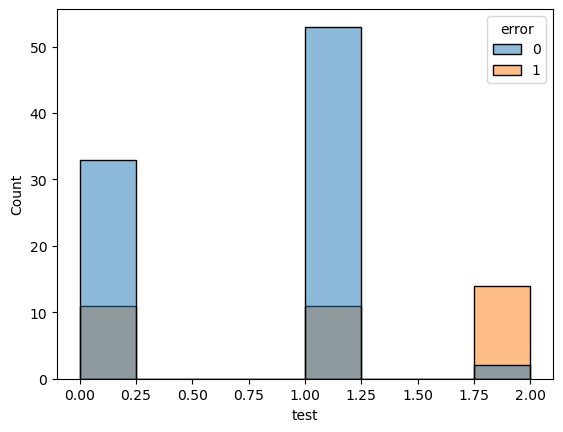

In [27]:
sns.histplot(data=result, x='test', hue='error')

<AxesSubplot:xlabel='test', ylabel='Count'>

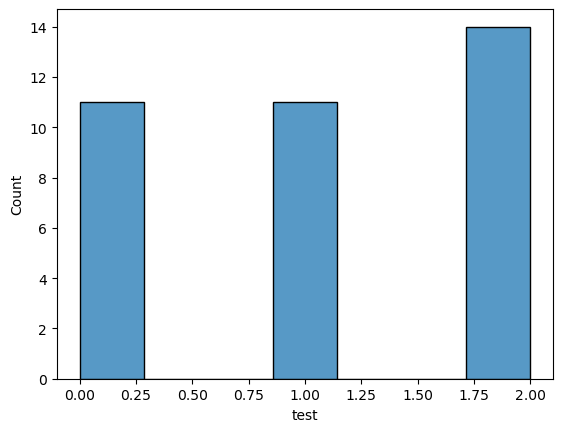

In [28]:
err = result[result['error'] == 1]
sns.histplot(err['test'])

<AxesSubplot:xlabel='predict', ylabel='Count'>

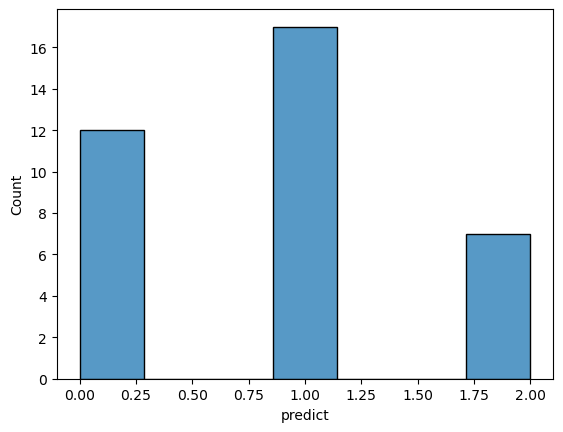

In [29]:
sns.histplot(err['predict'])

## Cнижение размерности

In [30]:
df_pca = df.copy()

In [31]:
df_pca.fillna(0, inplace=True)

In [32]:
num_cols = list(set(df_pca.columns.tolist()) - set(cat_cols))

In [33]:
def pca_pipeline(df, y, cat_cols, num_cols, n_components=50, pca=True):
    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())])

    categorical_transformer = Pipeline(steps=[
        ('target_encoding', TargetEncoder())])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols)])

    if pca:
        pca = PCA(n_components=n_components, random_state=42)
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('pca', pca)])

    else:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    X_processed = pipeline.fit_transform(df, y)

    return X_processed, pipeline

In [34]:
preds = []
tests = []
proba = []

for train_index, test_index in tscv.split(df_pca, y):
    y_train = y.iloc[train_index]
    X_train, processed = pca_pipeline(df_pca.iloc[train_index], y_train, cat_cols, num_cols)    

    X_test = processed.transform(df_pca.iloc[test_index])
    y_test = y.iloc[test_index]

    class_counts = np.bincount(y_train) #количество экземпляров каждого класса
    total_samples = np.sum(class_counts) #общее количество экземпляров
    class_weights = total_samples / (len(class_counts) * class_counts) #веса классов
    
    model = CatBoostClassifier(verbose=False, class_weights=class_weights, loss_function='MultiClass', task_type='GPU', **param_boost)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=False)
    pred = model.predict(X_test)
    proba.extend(model.predict_proba(X_test))
    preds.extend(pred.reshape(-1).tolist())
    tests.extend(y_test.tolist())
    print('f1 score weighted:', f1_score(y_test, pred, average='weighted'))

f1 score weighted: 0.4066176470588235
f1 score weighted: 0.5038461538461539
f1 score weighted: 0.39961722488038276
f1 score weighted: 0.5
f1 score weighted: 0.3833333333333333
f1 score weighted: 0.6769230769230768
f1 score weighted: 0.47666666666666674
f1 score weighted: 0.40555555555555556
f1 score weighted: 0.4489952153110048
f1 score weighted: 0.7038961038961041
f1 score weighted: 0.49000000000000005
f1 score weighted: 0.7045454545454545
f1 score weighted: 0.5166666666666666
f1 score weighted: 0.6509803921568628
f1 score weighted: 0.6949275362318841
f1 score weighted: 0.5708508403361345
f1 score weighted: 0.4040404040404041
f1 score weighted: 0.33506493506493507
f1 score weighted: 0.5174242424242425
f1 score weighted: 0.7318614718614719


In [35]:
print('f1 score weighted:', f1_score(tests, preds, average='weighted'))

f1 score weighted: 0.5257159149094633


In [36]:
predict, indx = [], []
for id, prob in enumerate(proba):
    if max(prob) > 0.4 and np.argmax(prob) == 2:
        predict.append(np.argmax(prob))
        indx.append(id)

    elif max(prob) > 0.48 and np.argmax(prob) in [0, 1]:
        predict.append(np.argmax(prob))
        indx.append(id) 

new_test = np.take(tests, indx)
print(len(tests), len(new_test))

400 121


In [37]:
result = pd.DataFrame({'predict': predict, 'test': new_test})
result['error'] = np.where(result['predict'] == result['test'], 0, 1)
result
print(f'f1_score: {f1_score(new_test, predict, average="weighted")}\naccuracy: {accuracy_score(new_test, predict)}')

f1_score: 0.663946624200324
accuracy: 0.6611570247933884


In [38]:
best_n_pca, best_f1_pca = 0, 0
for n in tqdm(range(50, 650, 50)): #количество компонент
    preds = []
    tests = []
    proba = []    

    for train_index, test_index in tscv.split(df_pca, y):
        y_train = y.iloc[train_index]
        X_train, processed = pca_pipeline(df_pca.iloc[train_index], y_train, cat_cols, num_cols, n_components=n)    

        X_test = processed.transform(df_pca.iloc[test_index])
        y_test = y.iloc[test_index]

        class_counts = np.bincount(y_train) #количество экземпляров каждого класса
        total_samples = np.sum(class_counts) #общее количество экземпляров
        class_weights = total_samples / (len(class_counts) * class_counts) #веса классов
        
        model = CatBoostClassifier(verbose=False, class_weights=class_weights, loss_function='MultiClass', task_type='GPU', **param_boost)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=False)
        pred = model.predict(X_test)
        proba.extend(model.predict_proba(X_test))
        preds.extend(pred.reshape(-1).tolist())
        tests.extend(y_test.tolist())

        
    predict, indx = [], []
    for id, prob in enumerate(proba):
        if max(prob) > 0.4 and np.argmax(prob) == 2:
            predict.append(np.argmax(prob))
            indx.append(id)

        elif max(prob) > 0.48 and np.argmax(prob) in [0, 1]:
            predict.append(np.argmax(prob))
            indx.append(id) 

    new_test = np.take(tests, indx)
    f1 = f1_score(new_test, predict, average='weighted')
    
    if f1 > best_f1_pca:
        best_f1_pca = f1
        best_n_pca = n   

    print(f'f1_score: {f1}\naccuracy: {accuracy_score(new_test, predict)}')
    print(f'best_n: {best_n_pca}, best_f1: {best_f1_pca}')

  8%|▊         | 1/12 [01:13<13:30, 73.69s/it]

f1_score: 0.663946624200324
accuracy: 0.6611570247933884
best_n: 50, best_f1: 0.663946624200324


 17%|█▋        | 2/12 [02:40<13:34, 81.46s/it]

f1_score: 0.6690702947845806
accuracy: 0.6746031746031746
best_n: 100, best_f1: 0.6690702947845806


 25%|██▌       | 3/12 [04:27<13:59, 93.30s/it]

f1_score: 0.6943862166539104
accuracy: 0.7096774193548387
best_n: 150, best_f1: 0.6943862166539104


 33%|███▎      | 4/12 [06:31<14:01, 105.23s/it]

f1_score: 0.7104300755414927
accuracy: 0.7168141592920354
best_n: 200, best_f1: 0.7104300755414927


 42%|████▏     | 5/12 [08:41<13:18, 114.13s/it]

f1_score: 0.7486084541508462
accuracy: 0.7547169811320755
best_n: 250, best_f1: 0.7486084541508462


 50%|█████     | 6/12 [11:08<12:31, 125.31s/it]

f1_score: 0.7192259913999044
accuracy: 0.7304347826086957
best_n: 250, best_f1: 0.7486084541508462


 58%|█████▊    | 7/12 [13:44<11:16, 135.24s/it]

f1_score: 0.7392187135777578
accuracy: 0.7549019607843137
best_n: 250, best_f1: 0.7486084541508462


 67%|██████▋   | 8/12 [16:45<10:00, 150.01s/it]

f1_score: 0.7202698869972337
accuracy: 0.7428571428571429
best_n: 250, best_f1: 0.7486084541508462


 75%|███████▌  | 9/12 [20:08<08:19, 166.35s/it]

f1_score: 0.7007477303559053
accuracy: 0.7326732673267327
best_n: 250, best_f1: 0.7486084541508462


 83%|████████▎ | 10/12 [23:57<06:11, 185.79s/it]

f1_score: 0.7507625600737734
accuracy: 0.7663551401869159
best_n: 500, best_f1: 0.7507625600737734


 92%|█████████▏| 11/12 [28:00<03:23, 203.33s/it]

f1_score: 0.7292857142857143
accuracy: 0.75
best_n: 500, best_f1: 0.7507625600737734


100%|██████████| 12/12 [32:26<00:00, 162.18s/it]

f1_score: 0.7249616480385713
accuracy: 0.7582417582417582
best_n: 500, best_f1: 0.7507625600737734


In [39]:
print(best_n_pca, best_f1_pca)

500 0.7507625600737734


Попробуем отобрать признаки с помощью дерева

In [43]:
f1, best_features = 0, 0
for n in tqdm(range(50, 650, 50)): #количество признаков с каждого фолда    
    features = []

    X, _ = pca_pipeline(df_pca, y, cat_cols, num_cols, pca=False)
    X = pd.DataFrame(X, columns=df_pca.columns)
    rf = RandomForestClassifier()

    selector = SelectFromModel(rf, max_features=n)
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    features.extend(selected_features)
        
    df_new = df_pca.loc[:, features]

    preds = []
    tests = []
    proba = []
    cat_feat = [feat for feat in features if feat in cat_cols]

    for train_index, test_index in tscv.split(df_new, y):
        y_train = y.iloc[train_index]
        X_train = df_new.iloc[train_index]

        X_test = df_new.iloc[test_index]
        y_test = y.iloc[test_index]

        class_counts = np.bincount(y_train) #количество экземпляров каждого класса
        total_samples = np.sum(class_counts) #общее количество экземпляров
        class_weights = total_samples / (len(class_counts) * class_counts) #веса классов
        
        model = CatBoostClassifier(verbose=False, class_weights=class_weights, loss_function='MultiClass', task_type='GPU', **param_boost)
        model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_feat, plot=False)
        pred = model.predict(X_test)
        proba.extend(model.predict_proba(X_test))
        preds.extend(pred.reshape(-1).tolist())
        tests.extend(y_test.tolist())

    predict, indx = [], []
    for id, prob in enumerate(proba):
        if max(prob) > 0.4 and np.argmax(prob) == 2:
            predict.append(np.argmax(prob))
            indx.append(id)

        elif max(prob) > 0.48 and np.argmax(prob) in [0, 1]:
            predict.append(np.argmax(prob))
            indx.append(id) 

    new_test = np.take(tests, indx)

    print(f'f1_score: {f1_score(new_test, predict, average="weighted")}\naccuracy: {accuracy_score(new_test, predict)}')

    if f1 < f1_score(new_test, predict, average="weighted"):
        f1 = f1_score(new_test, predict, average="weighted")
        best_features = features        

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [01:53<20:45, 113.27s/it]

f1_score: 0.7284768349277954
accuracy: 0.736


 17%|█▋        | 2/12 [03:47<18:55, 113.58s/it]

f1_score: 0.699737532808399
accuracy: 0.7165354330708661


 25%|██▌       | 3/12 [05:46<17:25, 116.20s/it]

f1_score: 0.7083506583506584
accuracy: 0.7207207207207207


 33%|███▎      | 4/12 [07:37<15:11, 114.00s/it]

f1_score: 0.7118164507470468
accuracy: 0.7383177570093458


 42%|████▏     | 5/12 [09:47<13:59, 119.99s/it]

f1_score: 0.7077342620967007
accuracy: 0.7235772357723578


 50%|█████     | 6/12 [12:01<12:27, 124.61s/it]

f1_score: 0.7107469502829773
accuracy: 0.7372881355932204


 58%|█████▊    | 7/12 [14:17<10:41, 128.31s/it]

f1_score: 0.7039315726290516
accuracy: 0.7321428571428571


 67%|██████▋   | 8/12 [16:38<08:49, 132.40s/it]

f1_score: 0.6882912176390437
accuracy: 0.7083333333333334


 75%|███████▌  | 9/12 [19:12<06:57, 139.26s/it]

f1_score: 0.7207357859531773
accuracy: 0.7258064516129032


 83%|████████▎ | 10/12 [21:33<04:39, 139.83s/it]

f1_score: 0.7350052246603971
accuracy: 0.7545454545454545


 92%|█████████▏| 11/12 [23:58<02:21, 141.42s/it]

f1_score: 0.7387700534759357
accuracy: 0.7636363636363637


100%|██████████| 12/12 [26:26<00:00, 132.23s/it]

f1_score: 0.7109768907563025
accuracy: 0.7226890756302521
